# Plug in SimPEG's gravity simulation into the new framework

In [1]:
import discretize
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
from simpeg.maps import IdentityMap
from simpeg.potential_fields.gravity import (
    Point,
    Simulation3DIntegral,
    SourceField,
    Survey,
)
from simpeg.utils import depth_weighting, model_builder

import inversion_ideas as ii

## Define synthetic data with two prisms

In [2]:
prisms = [
    (-60, -40, -10, 10, -70, -50),
    (40, 60, -10, 10, -70, -50),
]
densities = np.array([-200, 200])  # SI units

region = (-100, 100, -100, 100)
shape = (31, 31)
height = 0
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

In [3]:
gz = hm.prism_gravity(coordinates, prisms, densities, field="g_z")
gz *= -1  # Invert sign to work with upward component

# Add noise
stderr = vd.maxabs(gz) * 0.01
gz += np.random.default_rng(seed=51).normal(scale=stderr, size=gz.shape)

print(f"{stderr=}")

stderr=np.float64(2.5745854651805945e-05)


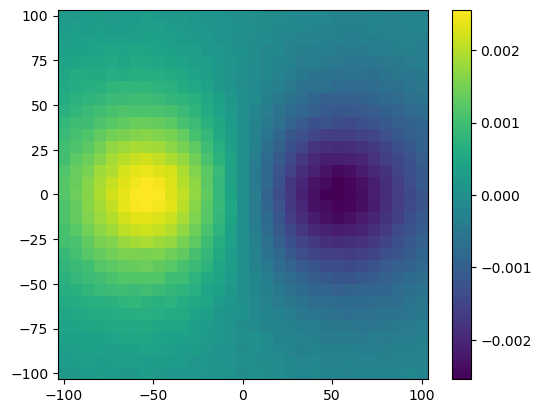

In [4]:
tmp = plt.pcolormesh(*coordinates[:2], gz)
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [5]:
gz.size

961

## Define SimPEG simulation

In [6]:
# h = [(5.0, 40)]
h = [(10.0, 20)]
mesh = discretize.TensorMesh(h=[h, h, h], origin="CCN")
mesh

TensorMesh: 8,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     20       -100.00        100.00     10.00     10.00    1.00
   y     20       -100.00        100.00     10.00     10.00    1.00
   z     20       -200.00          0.00     10.00     10.00    1.00

In [7]:
locations = np.vstack(tuple(c.ravel() for c in coordinates)).T
receivers = Point(locations, components="gz")
source = SourceField(receiver_list=[receivers])
survey = Survey(source)

In [8]:
simulation_simpeg = Simulation3DIntegral(mesh, survey=survey, rhoMap=IdentityMap(mesh))

In [9]:
def block_corners(prism):
    p0 = np.array([prism[0], prism[2], prism[4]])
    p1 = np.array([prism[1], prism[3], prism[5]])
    return p0, p1

In [10]:
model = np.zeros(mesh.n_cells)
densities_gcc = densities * 1e-3
print(densities_gcc)

for prism, density in zip(prisms, densities_gcc, strict=True):
    p0, p1 = block_corners(prism)
    model = model_builder.add_block(mesh.cell_centers, model, p0, p1, density)

[-0.2  0.2]


(<matplotlib.collections.QuadMesh at 0x7f1727fc1e50>,)

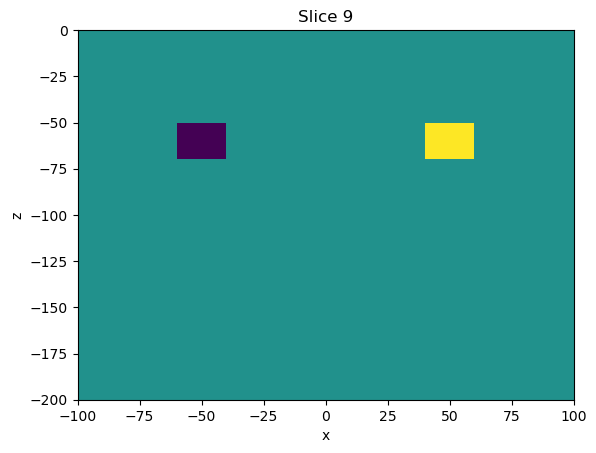

In [11]:
mesh.plot_slice(model, normal="Y", slice_loc=0)

In [12]:
dpred = simulation_simpeg.dpred(model)

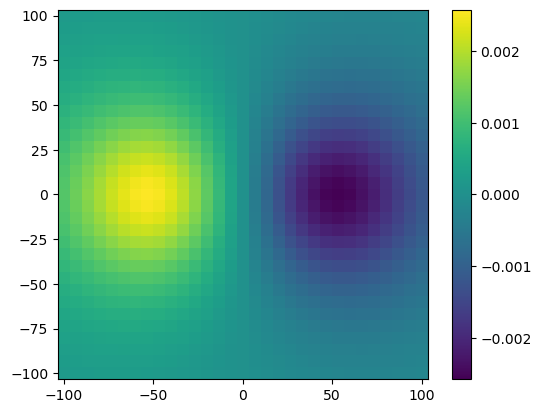

In [13]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

## Sparse gravity inversion

Wrap SimPEG's simulation into a child of the new `Simulation` class:

In [14]:
simulation = ii.wrap_simulation(simulation_simpeg, store_jacobian=True)

In [15]:
uncertainties = stderr * np.ones(gz.size)
data_misfit = ii.DataMisfit(gz.ravel(), uncertainties, simulation)

In [16]:
volume_weights = mesh.cell_volumes
depth_weights = depth_weighting(mesh, 0)
sparse_smallness = ii.SparseSmallness(
    n_params=simulation.n_params,
    norm=1,
    model_previous=None,
    weights=volume_weights * depth_weights,
    irls=False,  # Start with IRLS deactivated
)

In [17]:
beta_0 = 1e4
regularization = beta_0 * sparse_smallness
phi = data_misfit + regularization
phi

φd(m) + 1.00e+04 φss(m)

In [18]:
# Initial model
initial_model = np.zeros(simulation.n_params)

# Minimizer
minimizer = ii.ConjugateGradient()

# Stopping criteria
chi_target = ii.ChiTarget(data_misfit, chi_target=1.0)

# Beta cooling
beta_cooler = ii.MultiplierCooler(regularization, cooling_factor=2.0)

# Preconditioner that updates on each iteration
preconditioner = ii.JacobiPreconditioner(phi)

# Inversion
l2_inversion = ii.Inversion(
    phi,
    initial_model,
    minimizer,
    directives=[beta_cooler],
    stopping_criteria=chi_target,
    cache_models=True,
    preconditioner=preconditioner,
)

In [19]:
model_l2 = l2_inversion.run()

Output()

INFO: 🎉 Inversion successfully finished due to stopping criteria.


In [20]:
l2_inversion.log.table

┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Iteration ┃ β        ┃ φ_d      ┃ φ_m      ┃ β φ_m    ┃ φ        ┃ χ        ┃
┡━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ 0         │ 1.00e+04 │ 1.67e+06 │ 0.00e+00 │ 0.00e+00 │ 1.67e+06 │ 1.74e+03 │
│ 1         │ 1.00e+04 │ 4.39e+05 │ 3.85e+01 │ 3.85e+05 │ 8.24e+05 │ 4.57e+02 │
│ 2         │ 5.00e+03 │ 2.33e+05 │ 6.74e+01 │ 3.37e+05 │ 5.70e+05 │ 2.42e+02 │
│ 3         │ 2.50e+03 │ 1.11e+05 │ 1.01e+02 │ 2.54e+05 │ 3.65e+05 │ 1.15e+02 │
│ 4         │ 1.25e+03 │ 4.70e+04 │ 1.37e+02 │ 1.71e+05 │ 2.18e+05 │ 4.89e+01 │
│ 5         │ 6.25e+02 │ 1.79e+04 │ 1.69e+02 │ 1.05e+05 │ 1.23e+05 │ 1.86e+01 │
│ 6         │ 3.12e+02 │ 6.47e+03 │ 1.94e+02 │ 6.05e+04 │ 6.70e+04 │ 6.73e+00 │
│ 7         │ 1.56e+02 │ 2.52e+03 │ 2.11e+02 │ 3.29e+04 │ 3.54e+04 │ 2.63e+00 │
│ 8         │ 7.81e+01 │ 1.26e+03 │ 2.22e+02 │ 1.73e+04 │ 1.86e+04 │ 1.31e+00 │
│ 9         │ 3.91e+01 │ 8.49e+02 │ 2.29e+02 │ 8.94e+03 │ 9.78e+03 │ 8.83e-01 │
└───────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘

In [21]:
l2_inversion.stopping_criteria.info(model_l2)

[x] ChiTarget
├── Condition: chi < chi_target
├── chi        = 8.83e-01
└── chi_target = 1.00e+00

(<matplotlib.collections.QuadMesh at 0x7f1725c01310>,)

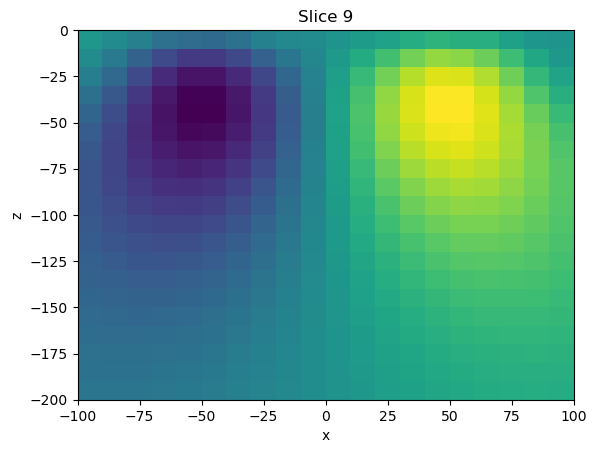

In [22]:
mesh.plot_slice(model_l2, normal="Y", slice_loc=0)

In [23]:
# Activate IRLS in smallness
# * Assign model to sparse smallness as previous model
# * Define epsilon: maximum abs value of the inverted model after the l2 inversion
sparse_smallness.activate_irls(model_l2)

# Define stopping criteria
smallness_not_changing = ii.ObjectiveChanged(sparse_smallness, rtol=1e-3)

# Define irls directive
irls_directive = ii.IRLS(
    sparse_smallness,
    data_misfit=data_misfit,
    regularization=regularization,
    model_stage_one=model_l2,
)

# Define sparse inversion
sparse_inversion = ii.Inversion(
    phi,
    model_l2,
    minimizer,
    directives=[irls_directive],
    stopping_criteria=smallness_not_changing,
    cache_models=True,
    max_iterations=80,
    preconditioner=preconditioner,
)

# Add columns to log
sparse_inversion.log.add_column(
    "irls threshold", lambda _, __: sparse_smallness.threshold
)
sparse_inversion.log.add_column(
    "|phi_m - phi_m*| / |phi_m*|", lambda _, model: smallness_not_changing.ratio(model)
)

In [24]:
model = sparse_inversion.run()

Output()

INFO: 🎉 Inversion successfully finished due to stopping criteria.


In [25]:
sparse_inversion.log.table

┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃           ┃          ┃          ┃          ┃          ┃          ┃          ┃                ┃ |phi_m - phi_m*| ┃
┃ Iteration ┃ β        ┃ φ_d      ┃ φ_m      ┃ β φ_m    ┃ φ        ┃ χ        ┃ irls threshold ┃ / |phi_m*|       ┃
┡━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ 0         │ 3.91e+01 │ 8.49e+02 │ 6.14e+04 │ 2.40e+06 │ 2.40e+06 │ 8.83e-01 │ 3.24e-03       │ nan              │
│ 1         │ 3.91e+01 │ 4.63e+05 │ 9.98e+03 │ 3.90e+05 │ 8.53e+05 │ 4.82e+02 │ 3.24e-03       │ 8.37e-01         │
│ 2         │ 1.47e+01 │ 1.82e+05 │ 2.16e+04 │ 3.17e+05 │ 4.99e+05 │ 1.89e+02 │ 3.24e-03       │ 1.16e+00         │
│ 3         │ 5.54e+00 │ 5.74e+04 │ 3.49e+04 │ 1.93e+05 │ 2.51e+05 │ 5.98e+01 │ 3.24e-03       │ 6.17e-01         │
│ 4         │ 2.12e+00 │ 1.50e+04 │ 4.66e+04 │ 9.86e+04 │ 1.14e+05 │ 1.56e+01 │ 3.24e-03       │ 3.36e-01         │
│ 5         │ 8.55e-01 │ 3.98e+03 │ 5.42e+04 │ 4.63e+04 │ 5.03e+04 │ 4.15e+00 │ 3.24e-03       │ 1.63e-01         │
│ 6         │ 4.12e-01 │ 1.66e+03 │ 5.79e+04 │ 2.38e+04 │ 2.55e+04 │ 1.73e+00 │ 3.24e-03       │ 6.87e-02         │
│ 7         │ 2.59e-01 │ 1.14e+03 │ 5.95e+04 │ 1.54e+04 │ 1.66e+04 │ 1.18e+00 │ 3.24e-03       │ 2.72e-02         │
│ 8         │ 1.94e-01 │ 9.58e+02 │ 6.02e+04 │ 1.17e+04 │ 1.27e+04 │ 9.97e-01 │ 3.24e-03       │ 1.32e-02         │
│ 9         │ 1.59e-01 │ 8.74e+02 │ 6.07e+04 │ 9.65e+03 │ 1.05e+04 │ 9.09e-01 │ 3.24e-03       │ 7.93e-03         │
│ 10        │ 1.59e-01 │ 9.27e+02 │ 6.94e+04 │ 1.10e+04 │ 1.20e+04 │ 9.65e-01 │ 2.59e-03       │ 1.44e-01         │
│ 11        │ 1.59e-01 │ 9.80e+02 │ 7.78e+04 │ 1.24e+04 │ 1.33e+04 │ 1.02e+00 │ 2.08e-03       │ 1.20e-01         │
│ 12        │ 1.28e-01 │ 8.88e+02 │ 7.84e+04 │ 1.01e+04 │ 1.10e+04 │ 9.24e-01 │ 2.08e-03       │ 8.21e-03         │
│ 13        │ 1.28e-01 │ 9.22e+02 │ 8.52e+04 │ 1.09e+04 │ 1.19e+04 │ 9.60e-01 │ 1.66e-03       │ 8.65e-02         │
│ 14        │ 1.28e-01 │ 9.49e+02 │ 9.00e+04 │ 1.16e+04 │ 1.25e+04 │ 9.88e-01 │ 1.33e-03       │ 5.64e-02         │
│ 15        │ 1.06e-01 │ 8.77e+02 │ 9.06e+04 │ 9.57e+03 │ 1.04e+04 │ 9.13e-01 │ 1.33e-03       │ 6.84e-03         │
│ 16        │ 1.06e-01 │ 8.95e+02 │ 9.31e+04 │ 9.83e+03 │ 1.07e+04 │ 9.32e-01 │ 1.06e-03       │ 2.73e-02         │
│ 17        │ 1.06e-01 │ 9.12e+02 │ 9.40e+04 │ 9.92e+03 │ 1.08e+04 │ 9.49e-01 │ 8.50e-04       │ 9.02e-03         │
│ 18        │ 1.06e-01 │ 9.28e+02 │ 9.36e+04 │ 9.88e+03 │ 1.08e+04 │ 9.65e-01 │ 6.80e-04       │ 3.56e-03         │
│ 19        │ 1.06e-01 │ 9.45e+02 │ 9.26e+04 │ 9.78e+03 │ 1.07e+04 │ 9.83e-01 │ 5.44e-04       │ 1.05e-02         │
│ 20        │ 8.70e-02 │ 8.93e+02 │ 9.32e+04 │ 8.11e+03 │ 9.00e+03 │ 9.30e-01 │ 5.44e-04       │ 5.76e-03         │
│ 21        │ 8.70e-02 │ 9.12e+02 │ 9.17e+04 │ 7.98e+03 │ 8.89e+03 │ 9.49e-01 │ 4.35e-04       │ 1.53e-02         │
│ 22        │ 8.70e-02 │ 9.31e+02 │ 9.04e+04 │ 7.86e+03 │ 8.80e+03 │ 9.69e-01 │ 3.48e-04       │ 1.48e-02         │
│ 23        │ 8.70e-02 │ 9.50e+02 │ 8.91e+04 │ 7.75e+03 │ 8.70e+03 │ 9.89e-01 │ 2.79e-04       │ 1.45e-02         │
│ 24        │ 7.15e-02 │ 9.11e+02 │ 8.96e+04 │ 6.40e+03 │ 7.31e+03 │ 9.48e-01 │ 2.79e-04       │ 5.54e-03         │
│ 25        │ 7.15e-02 │ 9.29e+02 │ 8.82e+04 │ 6.31e+03 │ 7.24e+03 │ 9.67e-01 │ 2.23e-04       │ 1.51e-02         │
│ 26        │ 7.15e-02 │ 9.47e+02 │ 8.71e+04 │ 6.22e+03 │ 7.17e+03 │ 9.85e-01 │ 1.78e-04       │ 1.31e-02         │
│ 27        │ 5.88e-02 │ 9.16e+02 │ 8.75e+04 │ 5.15e+03 │ 6.07e+03 │ 9.54e-01 │ 1.78e-04       │ 5.43e-03         │
│ 28        │ 5.88e-02 │ 9.33e+02 │ 8.64e+04 │ 5.08e+03 │ 6.02e+03 │ 9.71e-01 │ 1.43e-04       │ 1.31e-02         │
│ 29        │ 5.88e-02 │ 9.48e+02 │ 8.54e+04 │ 5.03e+03 │ 5.97e+03 │ 9.87e-01 │ 1.14e-04       │ 1.12e-02         │
│ 30        │ 4.84e-02 │ 9.24e+02 │ 8.59e+04 │ 4.16e+03 

In [26]:
sparse_inversion.stopping_criteria.info(sparse_inversion.model)

[x] ObjectiveChanged
├── Condition: |φ(m) - φ(m_prev)| <= max(|φ(m_prev)| * rtol, atol)
├── |φ(m) - φ(m_prev)| = 8.09e+01
├── |φ(m_prev)|        = 8.11e+04
├── rtol               = 1.00e-03
└── atol               = 0.00e+00

In [27]:
log = sparse_inversion.log.to_pandas()
log

,beta,phi_d,phi_m,beta * phi_m,phi,chi,irls threshold,|phi_m - phi_m*| / |phi_m*|
iter,,,,,,,,
0,39.062500,848.654748,61414.611547,2.399008e+06,2.399857e+06,0.883095,3.242970e-03,NaN
1,39.062500,463483.414982,9981.152161,3.898888e+05,8.533722e+05,482.292836,3.242970e-03,0.837479
2,14.684200,182022.728459,21554.240503,3.165068e+05,4.985295e+05,189.409707,3.242970e-03,1.159494
3,5.540806,57442.593820,34854.493349,1.931220e+05,2.505646e+05,59.773771,3.242970e-03,0.617060
4,2.118732,14955.084179,46557.616368,9.864312e+04,1.135982e+05,15.562002,3.242970e-03,0.335771
...,...,...,...,...,...,...,...,...
60,0.012823,917.857864,81357.064544,1.043259e+03,1.961116e+03,0.955107,6.735385e-07,0.001302
61,0.012823,918.028211,81258.230295,1.041991e+03,1.960019e+03,0.955284,5.388308e-07,0.001215
62,0.012823,918.185156,81165.956205,1.040808e+03,1.958993e+03,0.955448,4.310646e-07,0.001136


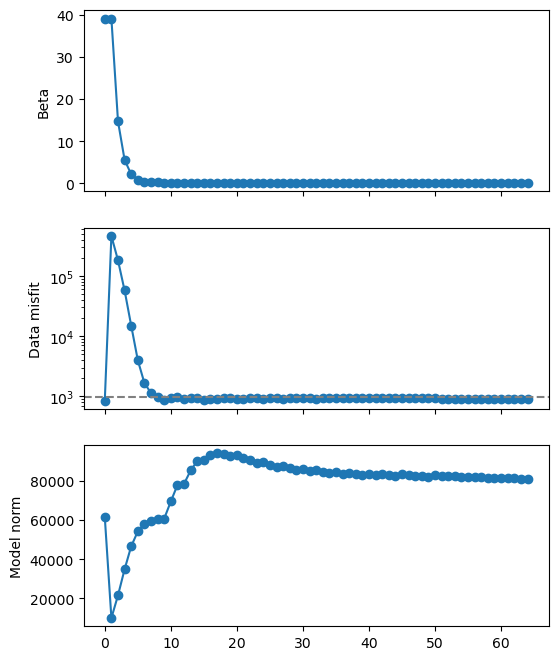

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8))
axes[0].plot(log.index, log.beta, "o-")
axes[0].set_ylabel("Beta")

axes[1].plot(log.index, log.phi_d, "o-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(log.index, log.phi_m, "o-")
axes[2].set_ylabel("Model norm")

plt.show()

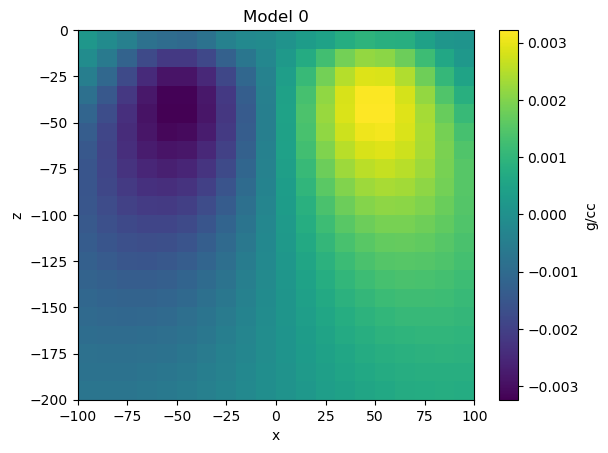

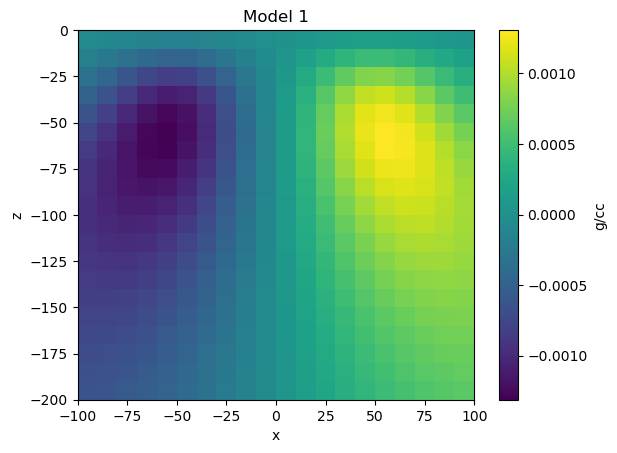

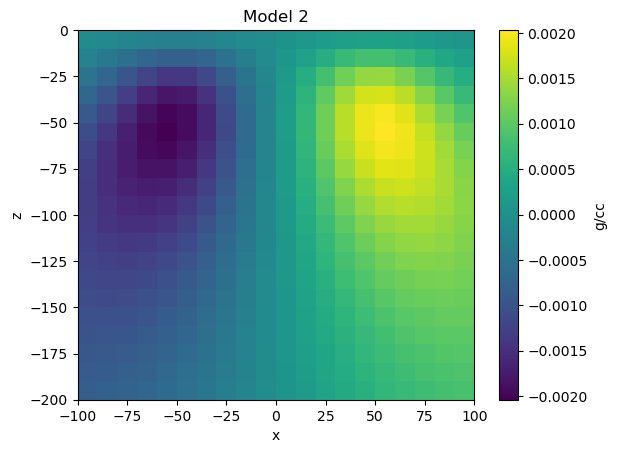

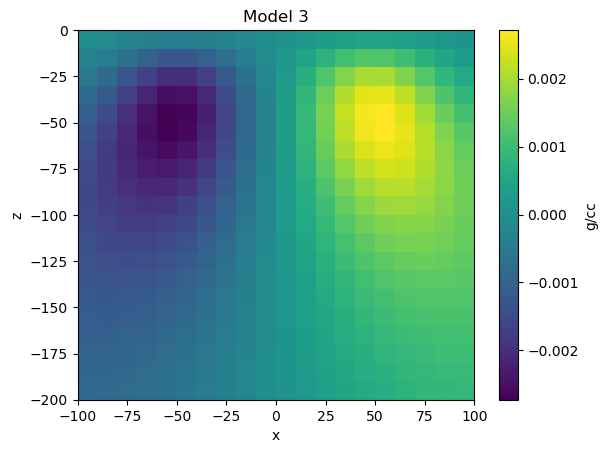

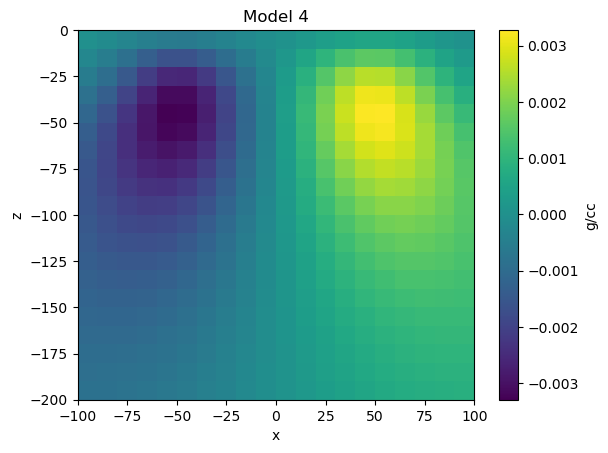

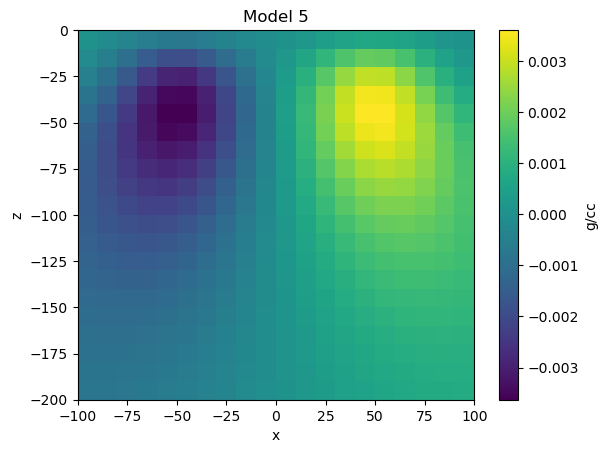

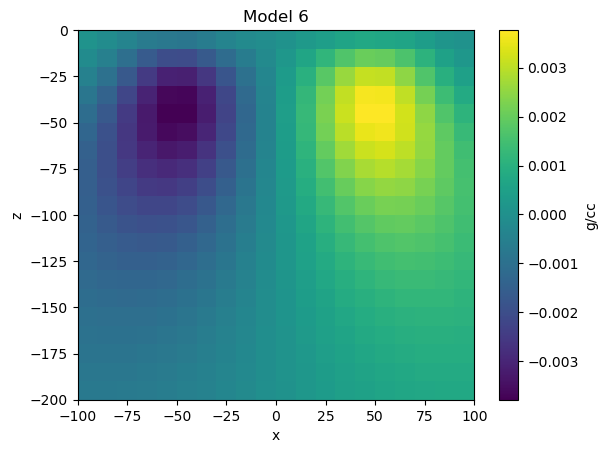

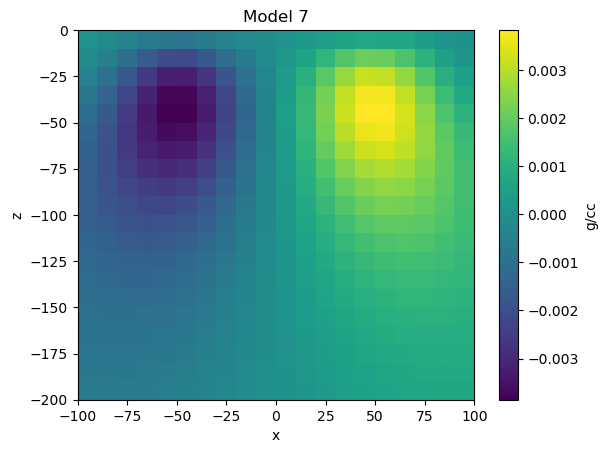

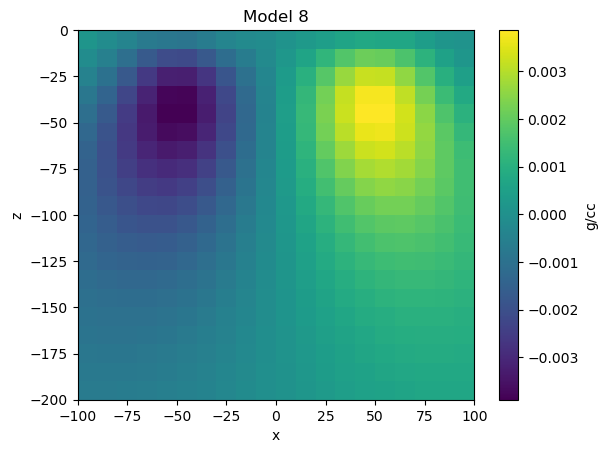

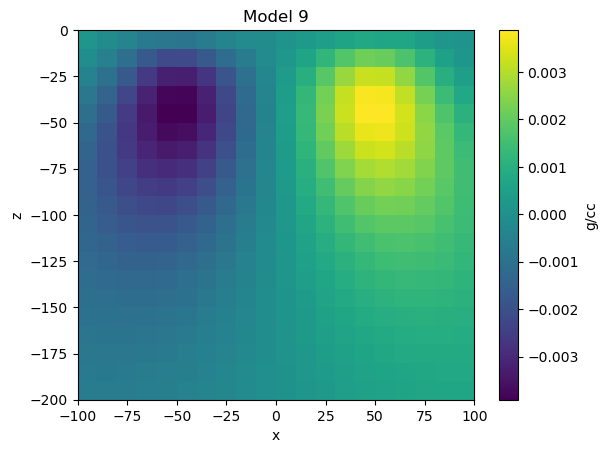

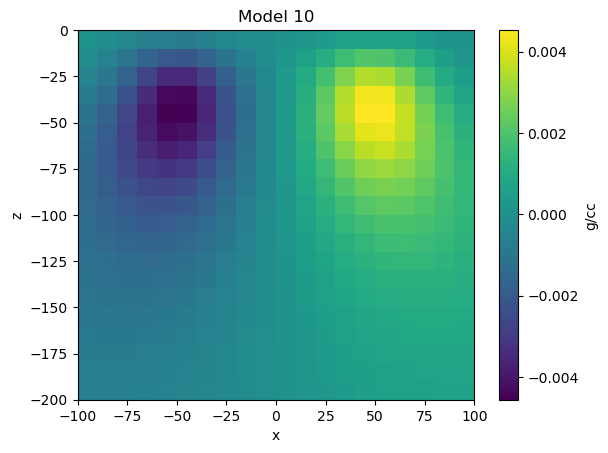

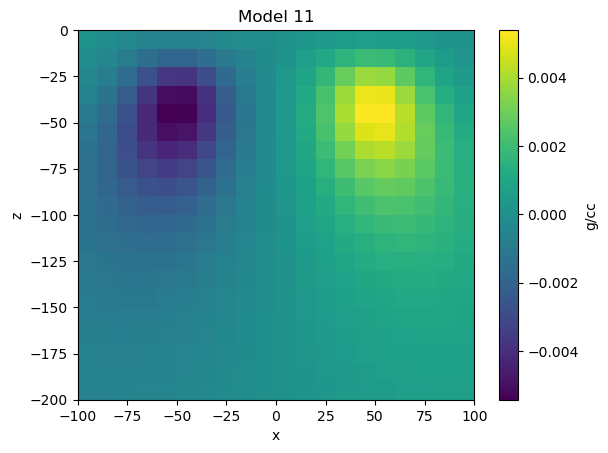

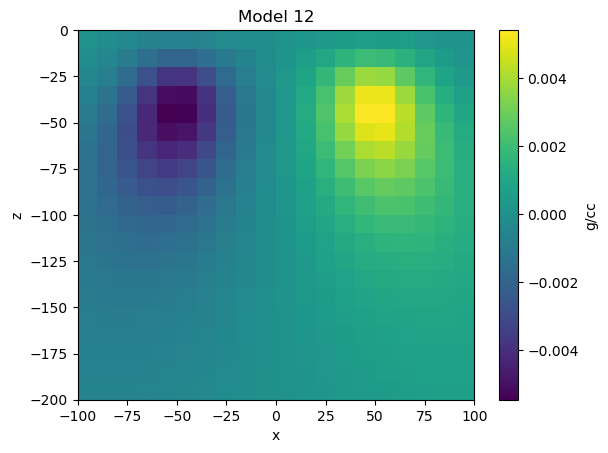

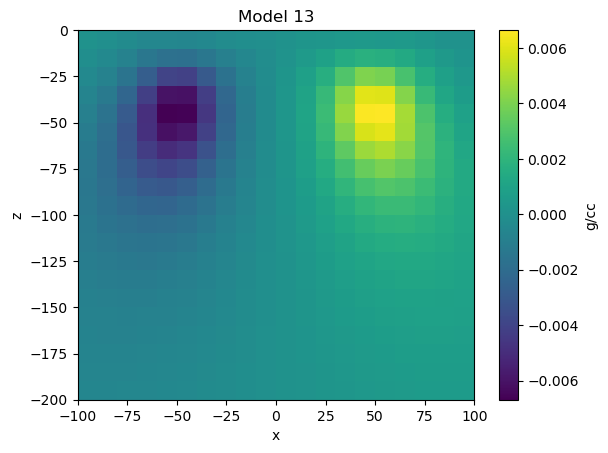

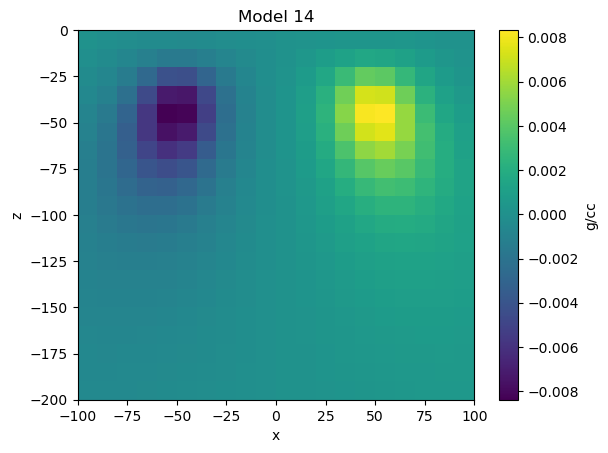

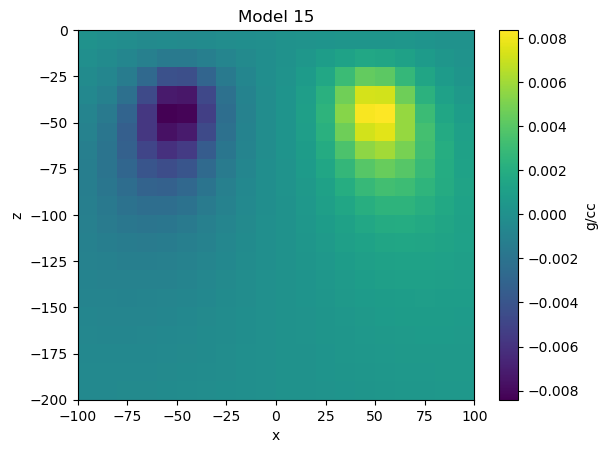

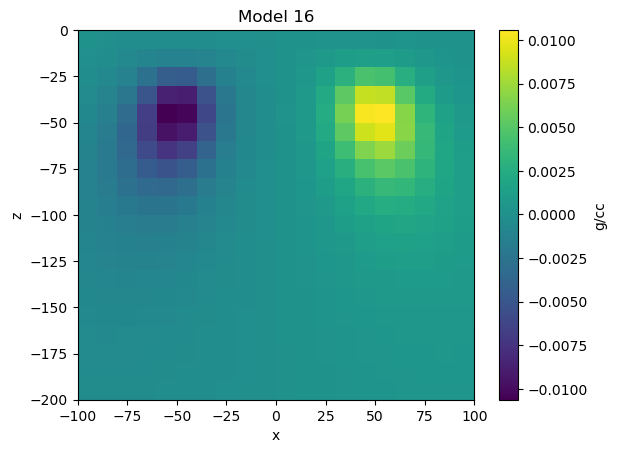

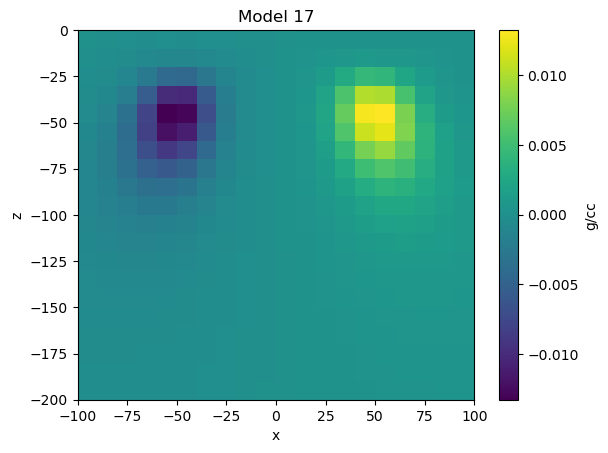

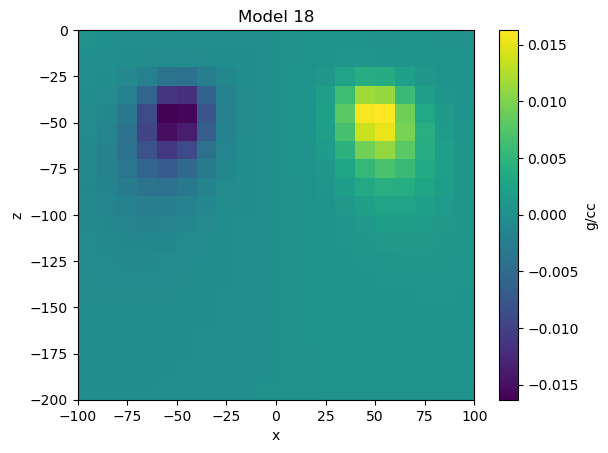

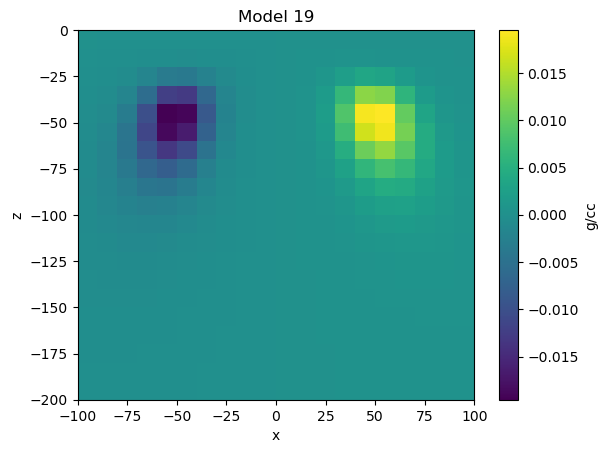

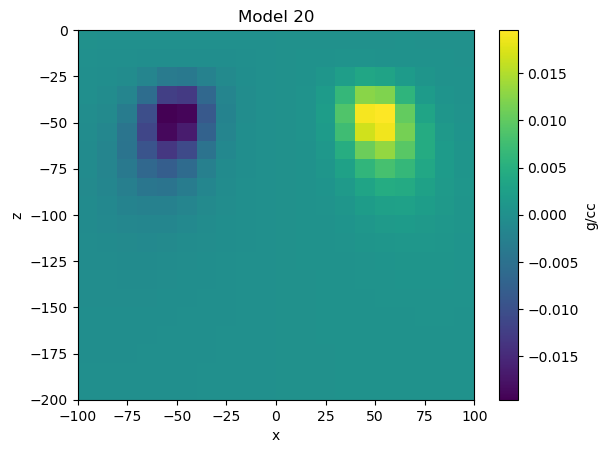

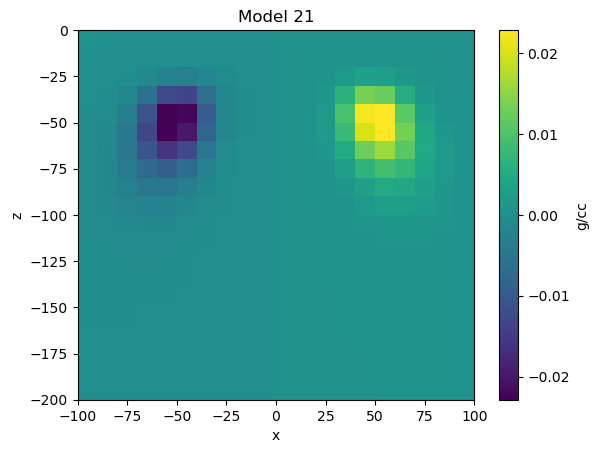

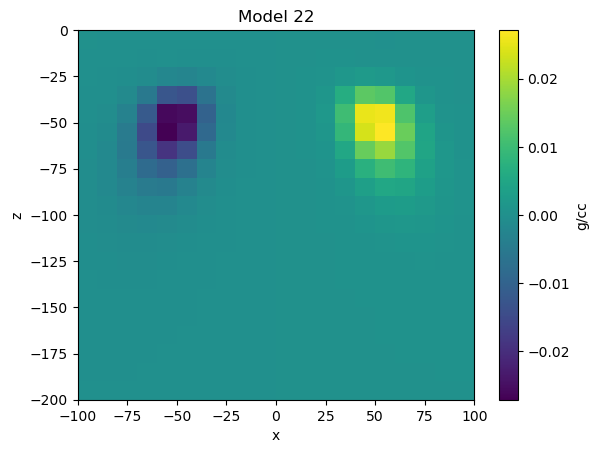

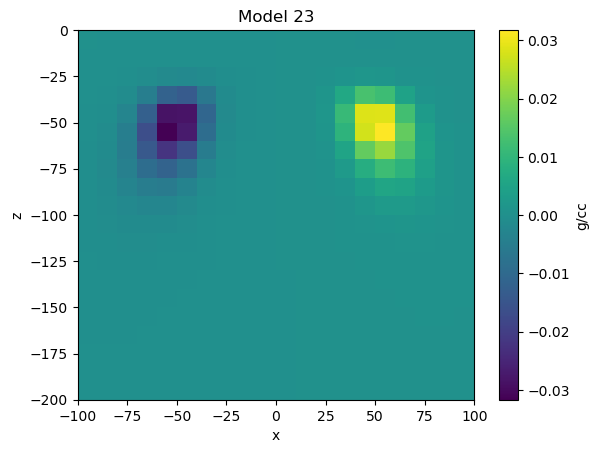

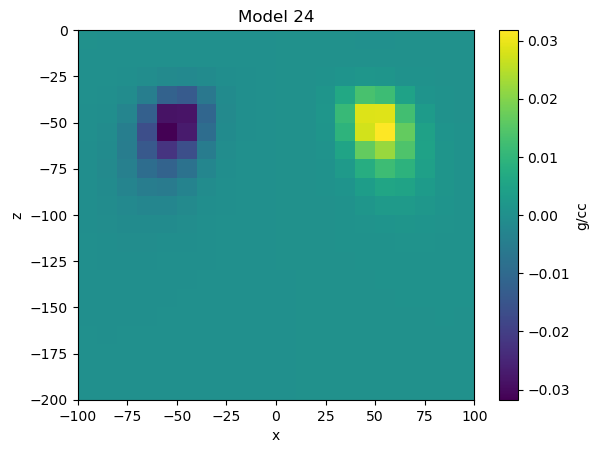

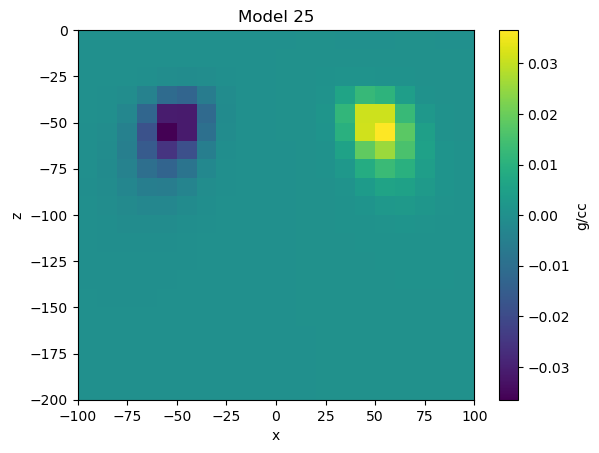

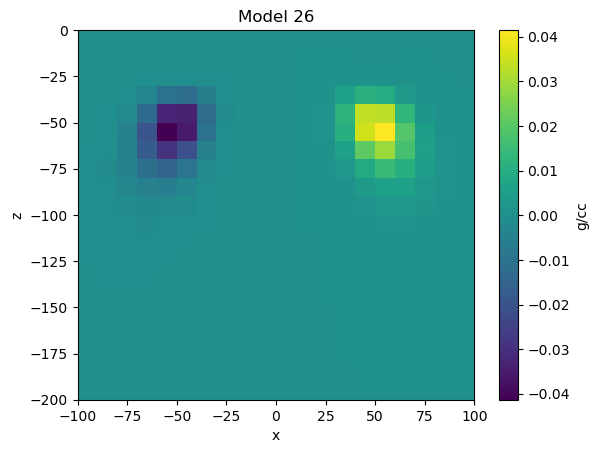

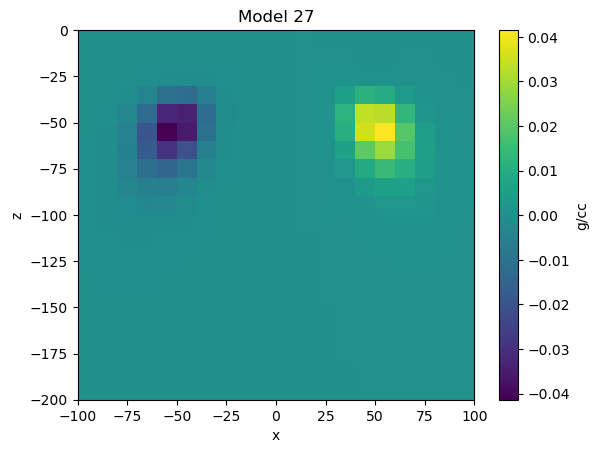

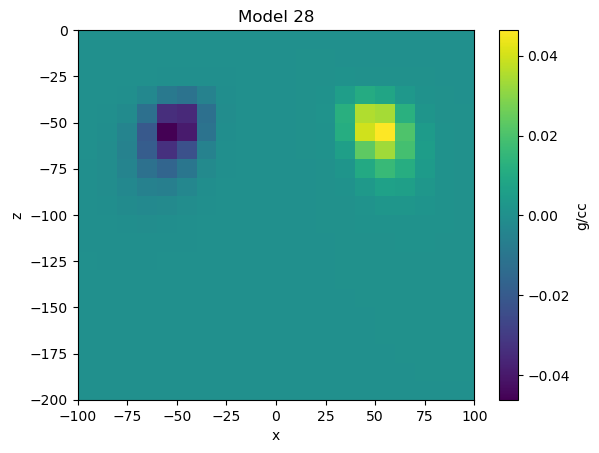

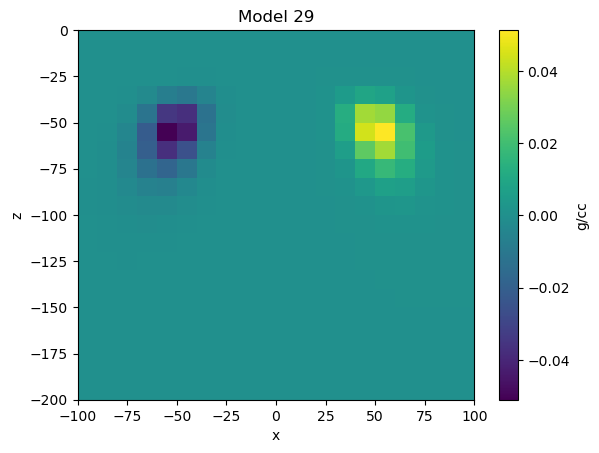

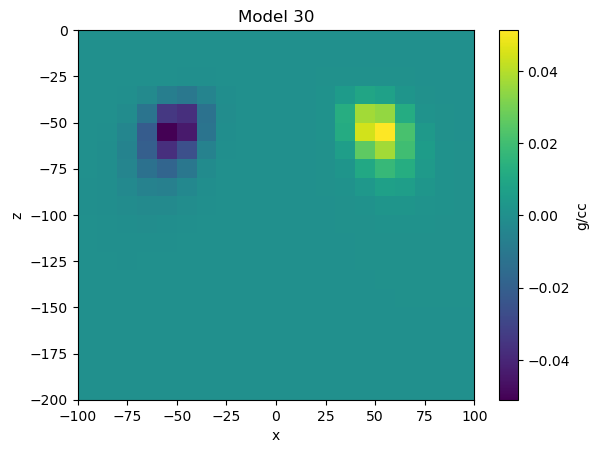

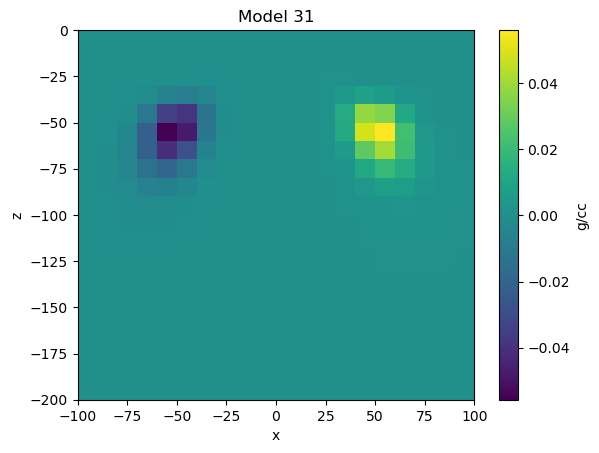

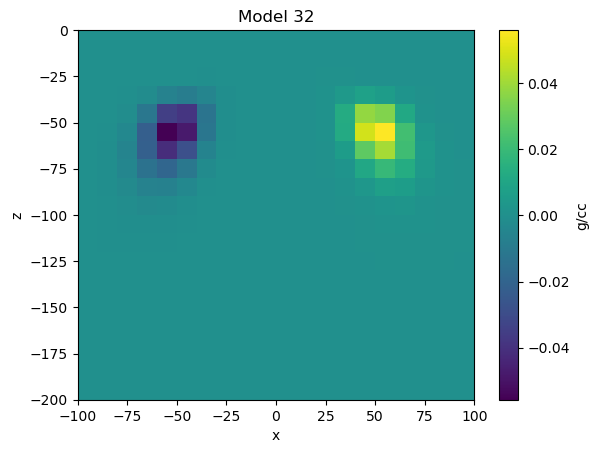

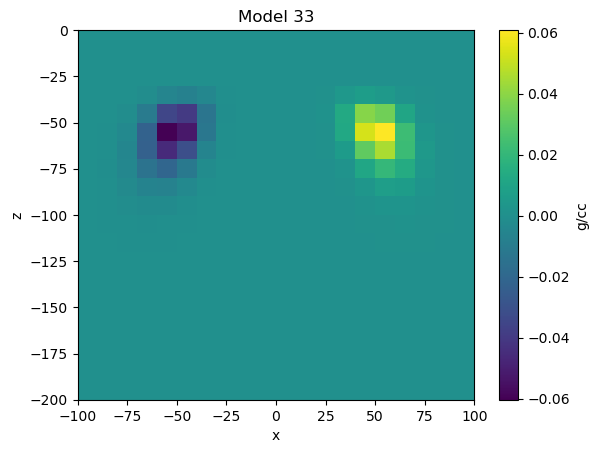

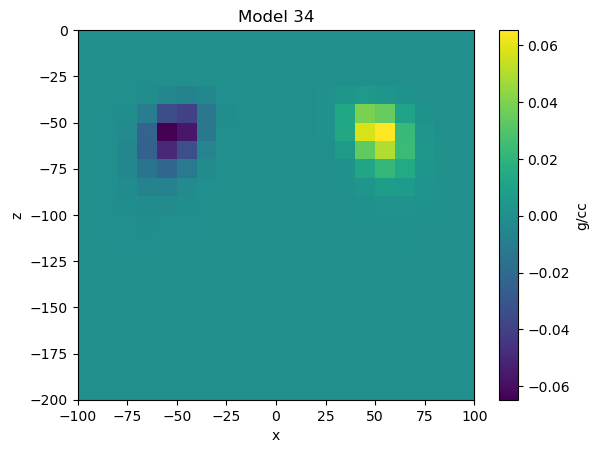

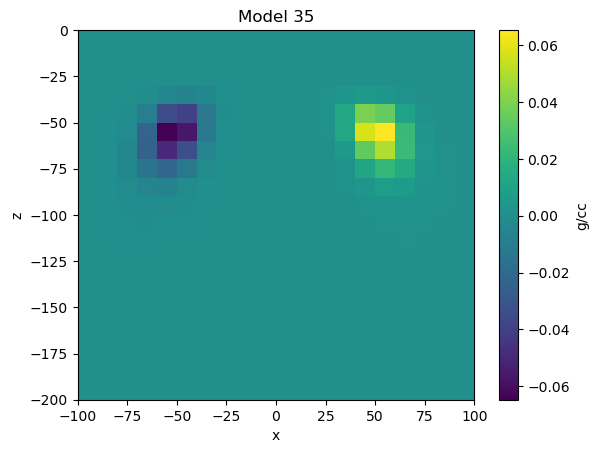

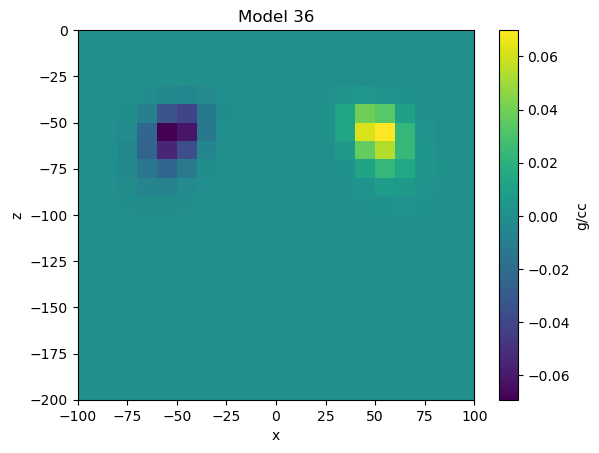

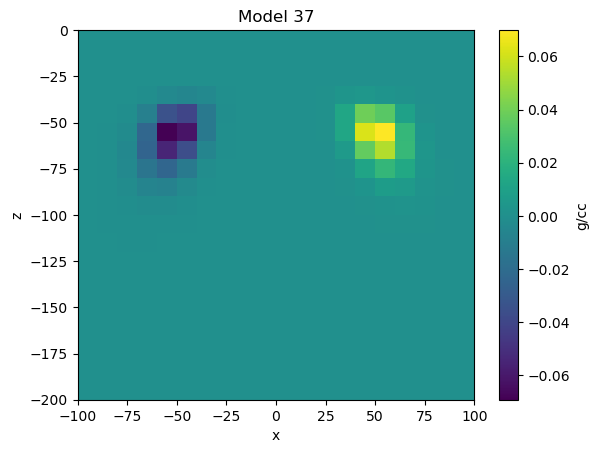

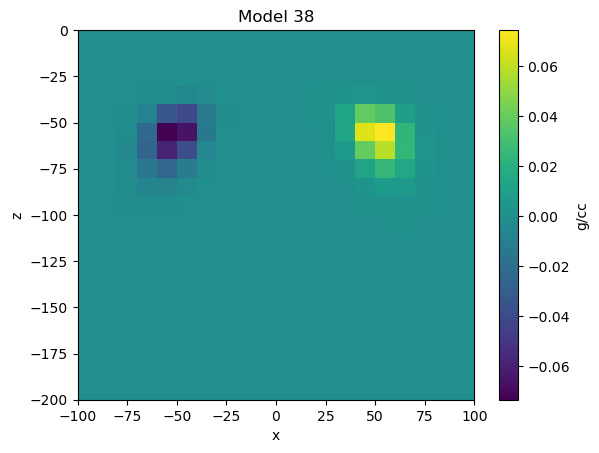

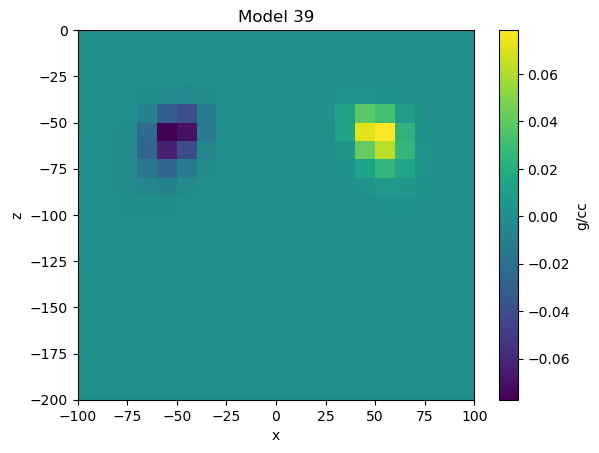

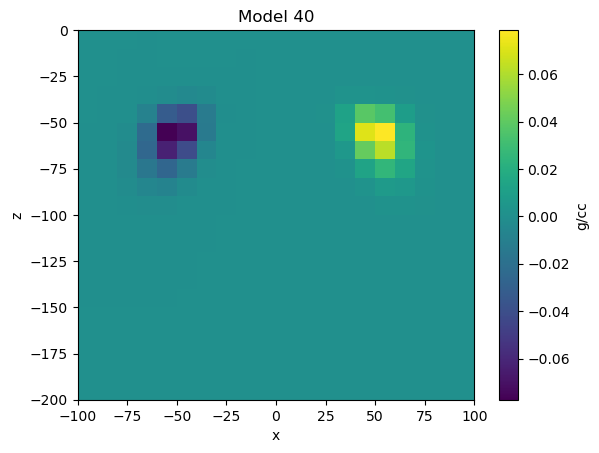

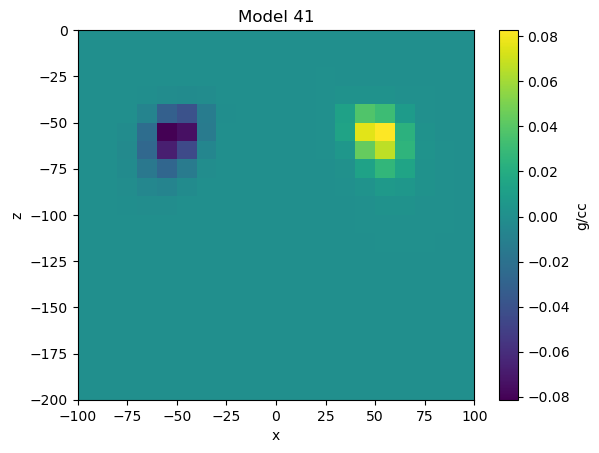

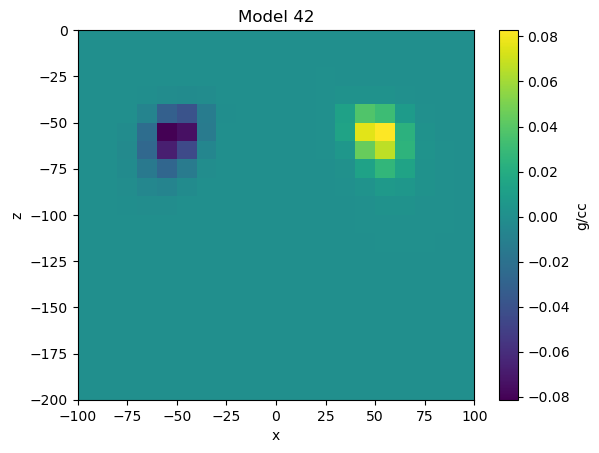

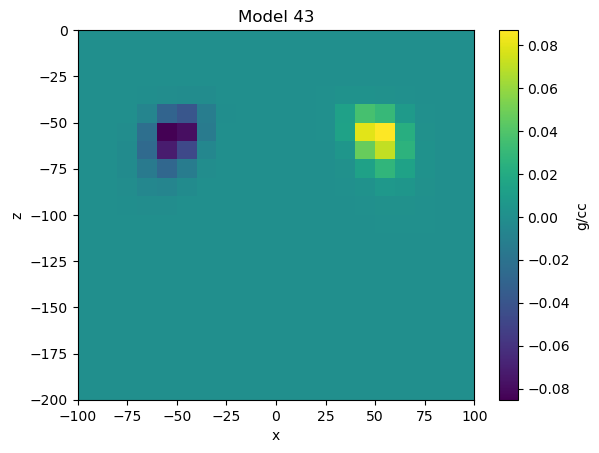

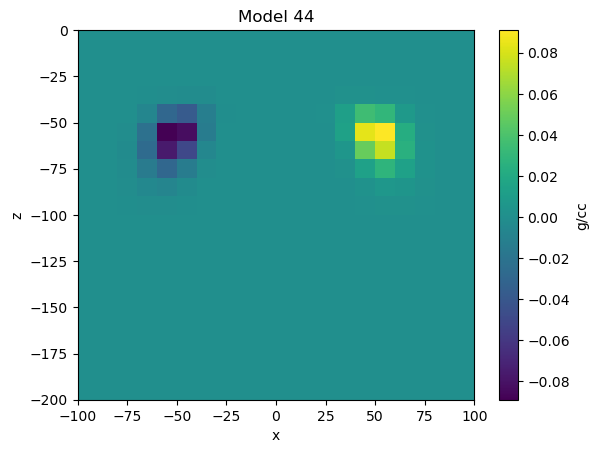

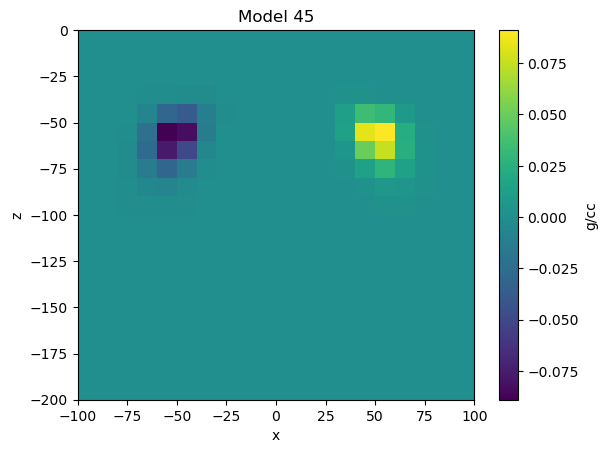

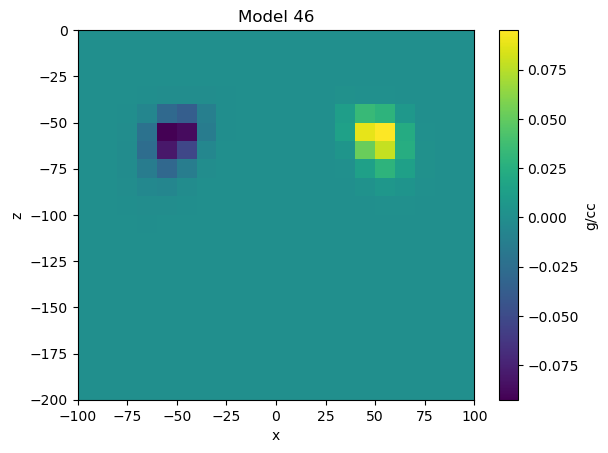

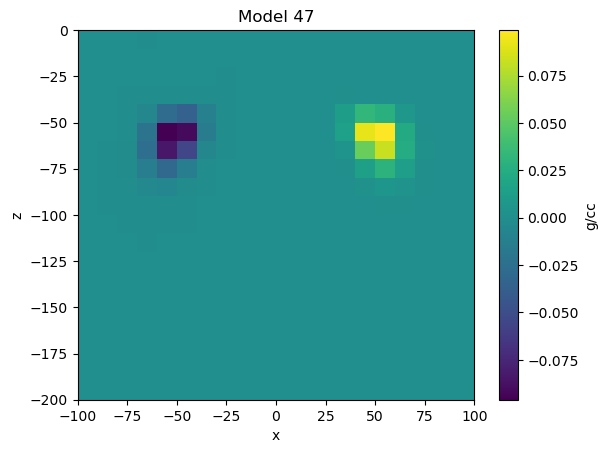

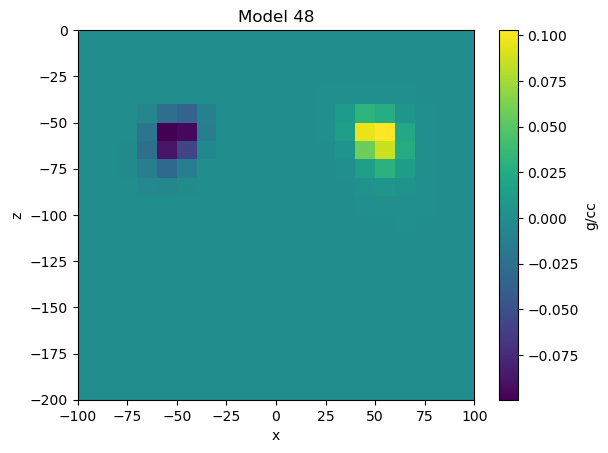

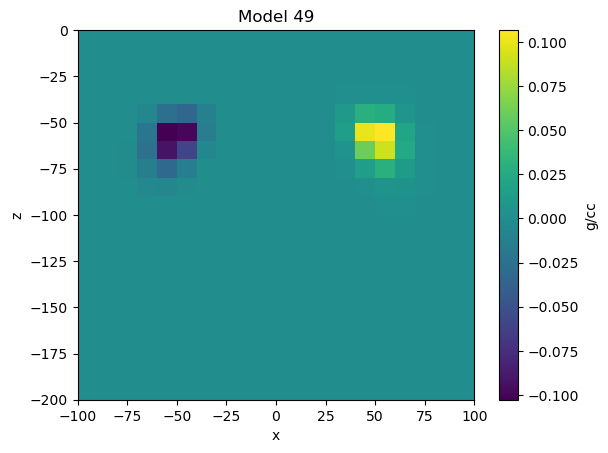

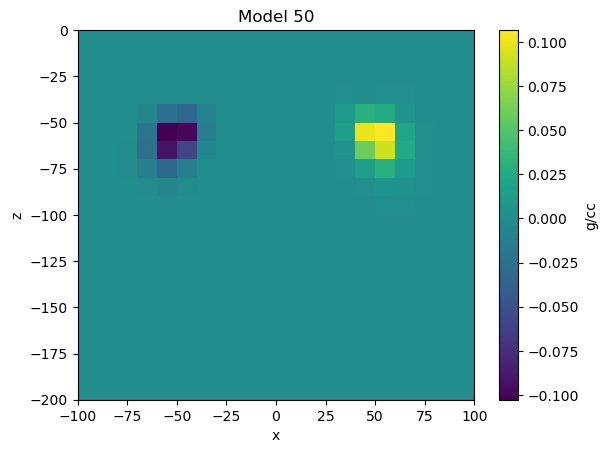

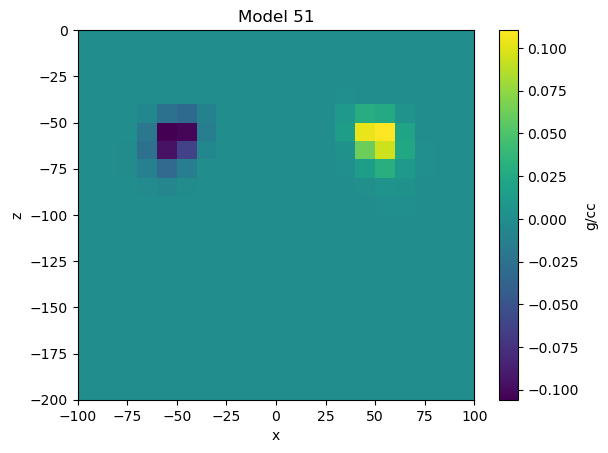

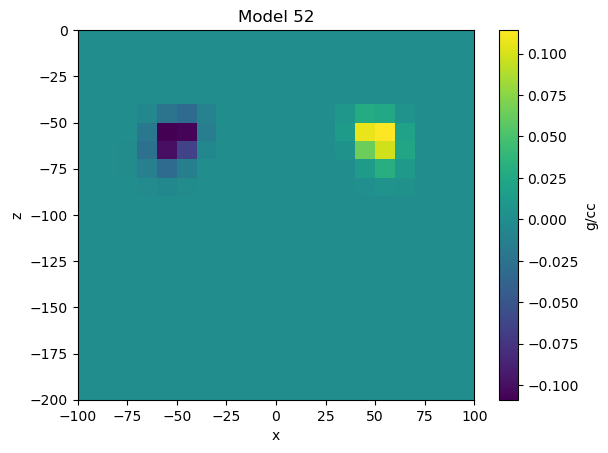

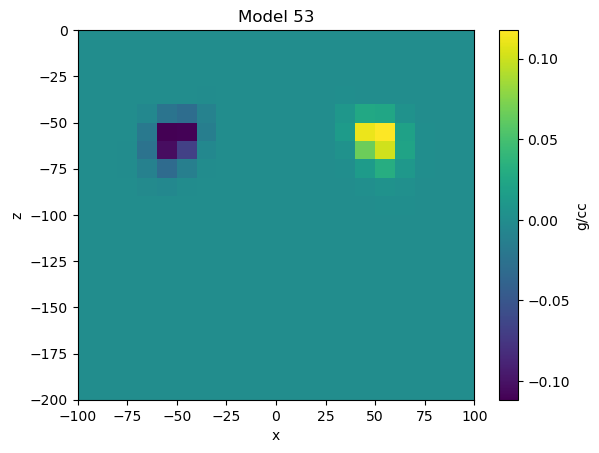

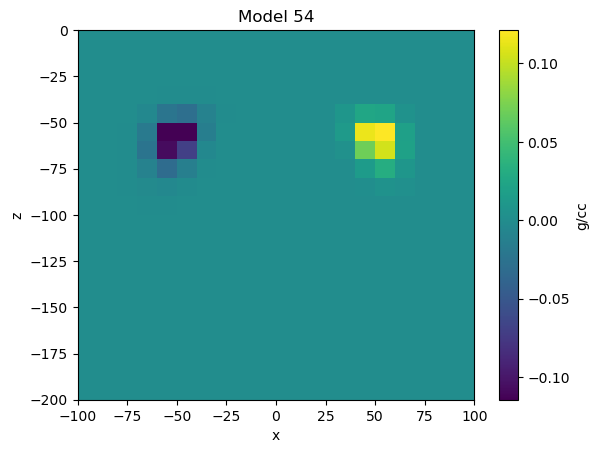

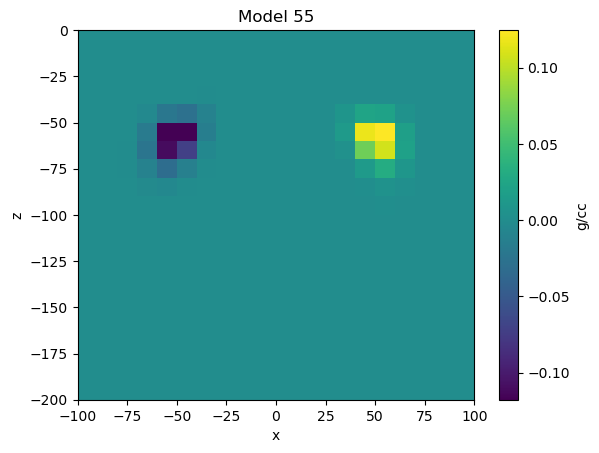

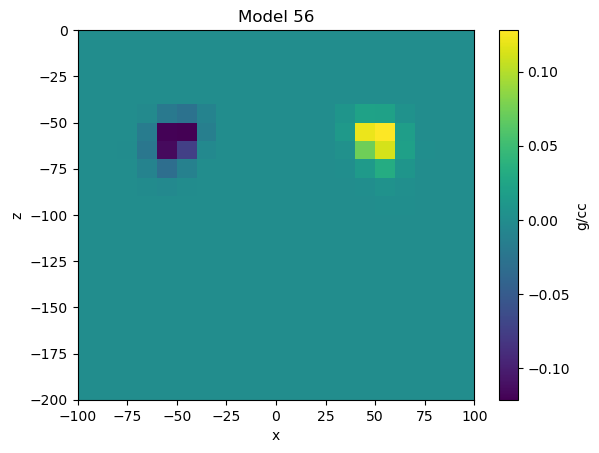

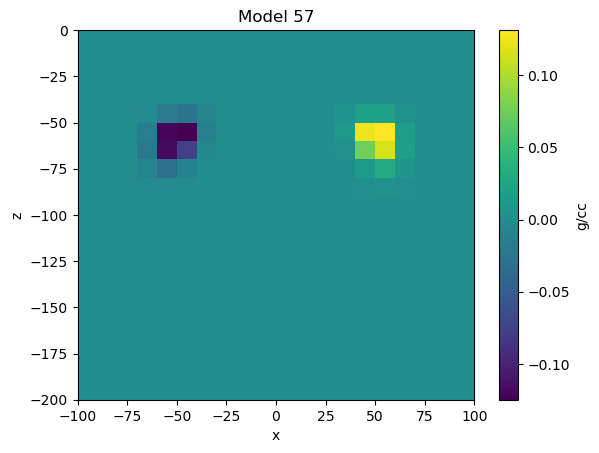

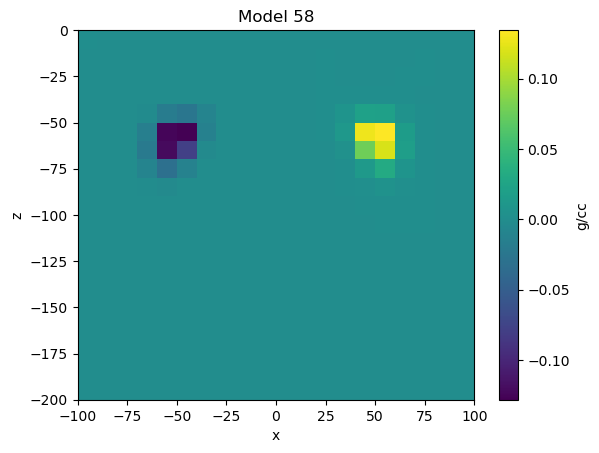

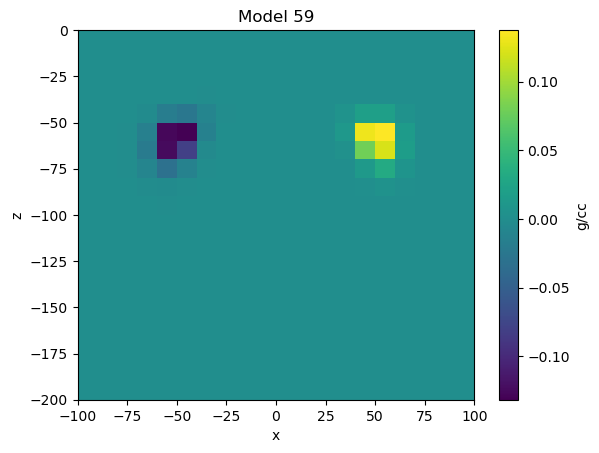

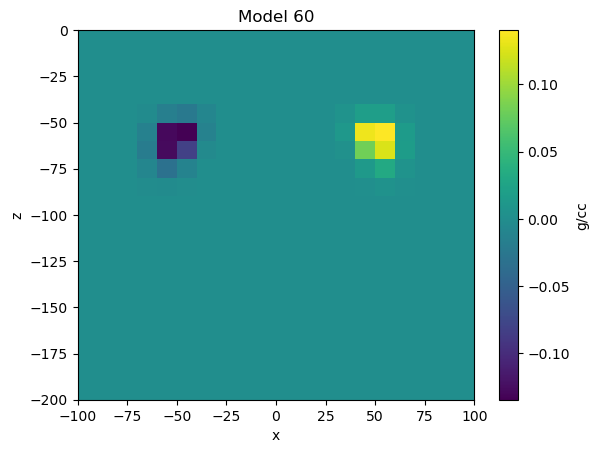

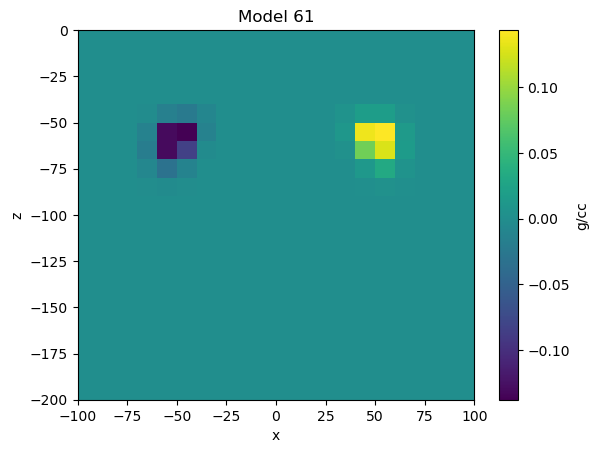

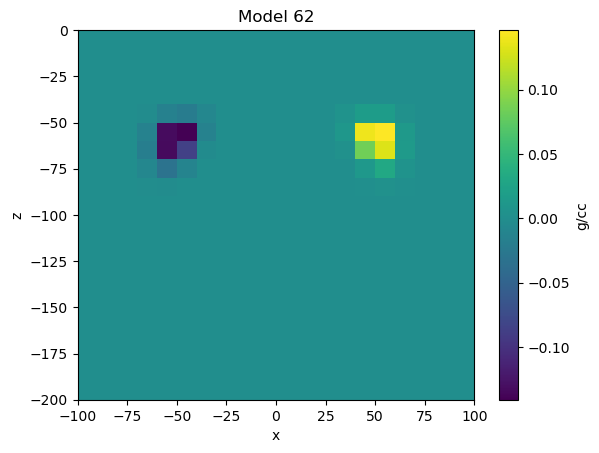

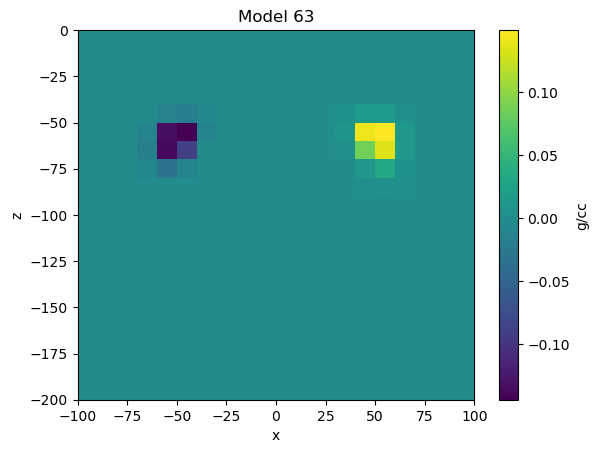

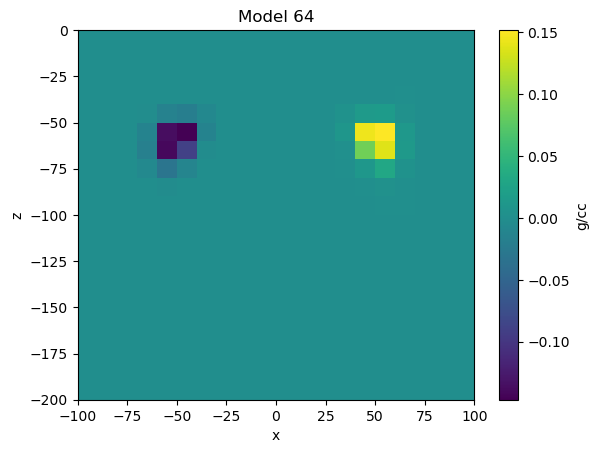

In [29]:
for i, model in enumerate(sparse_inversion.models):
    (tmp,) = mesh.plot_slice(model, normal="Y", slice_loc=0)
    plt.colorbar(tmp, label="g/cc")
    plt.title(f"Model {i}")
    plt.show()